In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
TRAIN = True
from torch.utils.data import DataLoader
from DataLoader import AfricanWildlifeDataset, show_image, show_images
from DenoisingAE import DenoisingAE, DenoisingAEV1, DenoisingAEV2
import torch
import gc
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

checkpoints = {
    "gaussian": {
        0.1: {
            "v0": "denoising_checkpoints/gaussian/0.1/v0/best.ckpt",
            "v1": "denoising_checkpoints/gaussian/0.1/v1/best.ckpt",
            "v2": "denoising_checkpoints/gaussian/0.1/v2/best.ckpt",
        },
        0.2: {
            "v0": "denoising_checkpoints/gaussian/0.2/v0/best.ckpt",
            "v1": "denoising_checkpoints/gaussian/0.2/v1/best.ckpt",
            "v2": "denoising_checkpoints/gaussian/0.2/v2/best.ckpt",
        },
    },
    "bernoulli": {
        0.1: {
            "v0": "denoising_checkpoints/bernoulli/0.1/v0/best.ckpt",
            "v1": "denoising_checkpoints/bernoulli/0.1/v1/best.ckpt",
            "v2": "denoising_checkpoints/bernoulli/0.1/v2/best.ckpt",
        },
        0.3: {
            "v0": "denoising_checkpoints/bernoulli/0.3/v0/best.ckpt",
            "v1": "denoising_checkpoints/bernoulli/0.3/v1/best.ckpt",
            "v2": "denoising_checkpoints/bernoulli/0.3/v2/best.ckpt",
        },
    },
}

torch.cuda.empty_cache()
gc.collect()

22

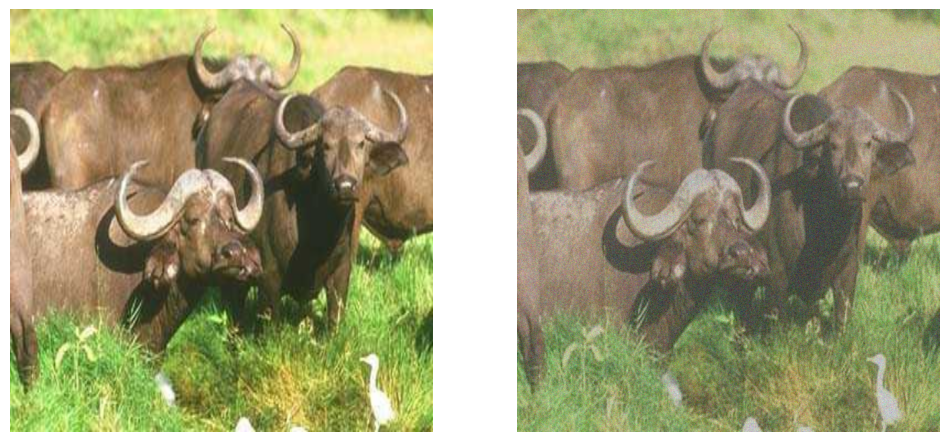

v2


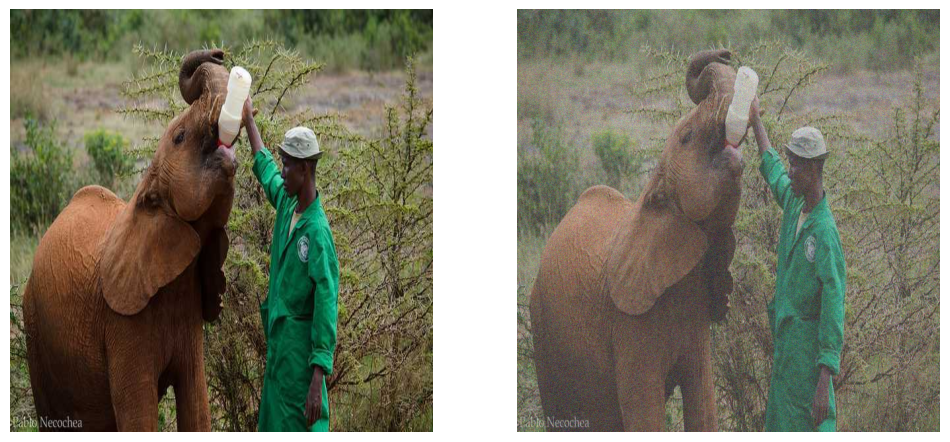

In [4]:
import gin

gin.parse_config_file("config.cfg")

train_dataset = AfricanWildlifeDataset()
val_dataset = AfricanWildlifeDataset(kind="valid")

img_index, original = train_dataset[888]
ae = DenoisingAE()
print(ae.kind)
decoded = ae(img_index)

show_images(original, img_index)

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, num_workers=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=8)

# Train

In [6]:
%%capture
if TRAIN:
    logger = TensorBoardLogger("tb_logs", name=f"salt_pepper/denoising_autoencoder_{ae.kind}")

    checkpoint_callback = ModelCheckpoint(save_top_k=1, save_last=True, monitor="val_loss")

    trainer = Trainer(logger=logger, max_epochs=150, callbacks=[checkpoint_callback])

    trainer.fit(model=ae, train_dataloaders=train_loader, val_dataloaders=val_loader)
%%capture

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-06-10 17:37:57.255712: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 17:37:57.413535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has 

# Examples of cleaned images

In [ ]:
def test_on_image(img_index, kind, noise_type, noise_value):
    if kind == "v1":
        # Need to call the class instance to load the checkpoint
        model = DenoisingAEV1
    elif kind == "v2":
        model = DenoisingAEV2
    else:
        model = DenoisingAE
    loaded = model.load_from_checkpoint(checkpoints[noise_type][noise_value][kind])
    assert loaded.kind == kind
    img_index, original = val_dataset[img_index]
    return loaded(img_index.to("cuda"))

/home/edoardo/anaconda3/envs/aiproject/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


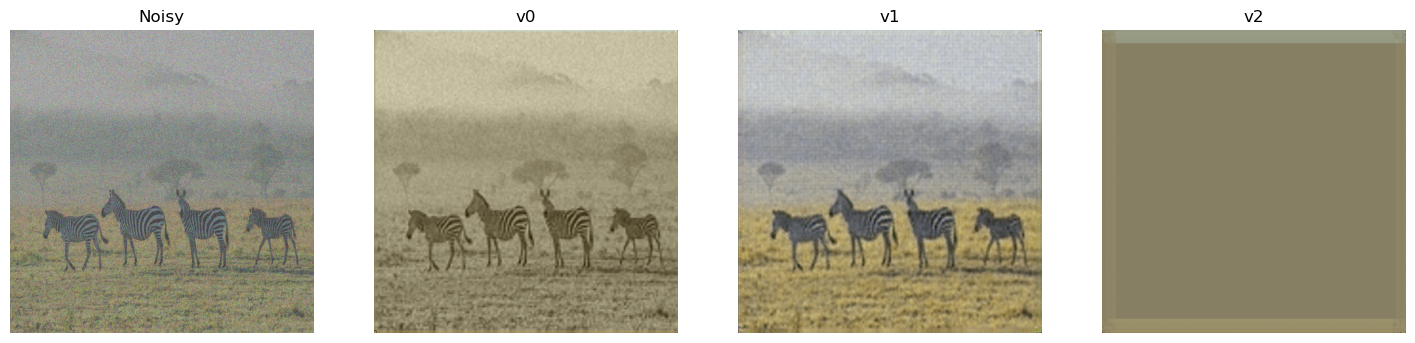

In [ ]:
img_to_pick = 49
img, _ = val_dataset[img_to_pick]
decodedv0 = test_on_image(img_to_pick, "v0", "gaussian", 0.1)
decodedv1 = test_on_image(img_to_pick, "v1", "gaussian", 0.1)
decodedv2 = test_on_image(img_to_pick, "v2", "gaussian", 0.1)
show_images(
    img,
    decodedv0.detach().cpu(),
    decodedv1.detach().cpu(),
    decodedv2.detach().cpu(),
    tags=["Noisy", "v0", "v1", "v2"],
)

# All